# Phase 1: EHF Data Setup & ERA5-Land Preprocessing

This notebook implements Phase 1 of the Excess Heat Factor (EHF) methodology:
- ERA5-Land data access and preprocessing
- City-based analysis setup using GHS urban database
- Temperature data extraction and aggregation

Based on Perkins & Alexander (2013) methodology for extreme heat assessment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys
from tqdm import tqdm

# Check for required packages and provide helpful error messages
try:
    import ee
    EE_AVAILABLE = True
    print("✅ Google Earth Engine API available")
except ImportError:
    EE_AVAILABLE = False
    print("❌ Google Earth Engine API not installed")

try:
    import geemap
    GEEMAP_AVAILABLE = True
    print(f"✅ Geemap available (version {geemap.__version__})")
except ImportError as e:
    GEEMAP_AVAILABLE = False
    print(f"❌ Geemap import error: {e}")
    print("Try: pip install geemap or conda install -c conda-forge geemap")

# Add src to path for utilities
sys.path.append('../src')
try:
    import gee_utils
    print("✅ GEE utilities loaded")
except ImportError:
    print("⚠️  GEE utilities not found, using basic functions")

print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version.split()[0]}")

# Initialize GEE with error handling
if EE_AVAILABLE:
    try:
        # Initialize with your project (same as other notebooks)
        ee.Initialize(project='tl-cities')
        print("✅ Google Earth Engine initialized successfully with tl-cities project")
        GEE_INITIALIZED = True
    except Exception as e:
        print(f"❌ Google Earth Engine initialization failed: {e}")
        GEE_INITIALIZED = False
else:
    GEE_INITIALIZED = False

print(f"\n{'='*60}")
print("ENVIRONMENT STATUS")
print(f"{'='*60}")
print(f"Earth Engine API: {'✅ Ready' if GEE_INITIALIZED else '❌ Not available'}")
print(f"Geemap: {'✅ Available' if GEEMAP_AVAILABLE else '❌ Not installed'}")

if GEE_INITIALIZED:
    print(f"Project: tl-cities")
    print("Ready for ERA5-Land data extraction!")

# Note about geemap
if not GEEMAP_AVAILABLE:
    print("\n⚠️  Note: Geemap is optional for EHF analysis")
    print("   Core functionality will work without it")

✅ Google Earth Engine API available
✅ Geemap available (version 0.36.1)
✅ GEE utilities loaded
Python executable: /Users/martynclark/heatInsights-notebooks/venv/bin/python
Python version: 3.9.13
✅ Google Earth Engine initialized successfully with tl-cities project

ENVIRONMENT STATUS
Earth Engine API: ✅ Ready
Geemap: ✅ Available
Project: tl-cities
Ready for ERA5-Land data extraction!


## 1.1 ERA5-Land Data Access

In [2]:
# ERA5-Land dataset configuration
ERA5_LAND = 'ECMWF/ERA5_LAND/HOURLY'
TEMPERATURE_BAND = 'temperature_2m'  # Kelvin

# Date range for analysis (using maximum available period for robust statistics)
START_DATE = '1950-01-01'
END_DATE = '2024-12-31'

print(f"ERA5-Land Configuration:")
print(f"Dataset: {ERA5_LAND}")
print(f"Variable: {TEMPERATURE_BAND}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Spatial resolution: ~11km")
print(f"Temporal resolution: Hourly")

# Verify ERA5-Land access
if GEE_INITIALIZED:
    print("\nTesting ERA5-Land data access...")
    try:
        era5_test = ee.ImageCollection(ERA5_LAND).limit(1)
        test_count = era5_test.size().getInfo()
        print(f"✅ ERA5-Land accessible - found {test_count} images in collection")
    except Exception as e:
        print(f"❌ ERA5-Land access error: {e}")
else:
    print("⚠️  GEE not initialized - cannot test ERA5-Land access")

ERA5-Land Configuration:
Dataset: ECMWF/ERA5_LAND/HOURLY
Variable: temperature_2m
Date range: 1950-01-01 to 2024-12-31
Spatial resolution: ~11km
Temporal resolution: Hourly

Testing ERA5-Land data access...
✅ ERA5-Land accessible - found 1 images in collection


## 1.2 City-based Analysis Setup

In [3]:
# Load global cities dataset
if GEE_INITIALIZED:
    print("Loading GHS Urban Database...")
    cities_collection = 'projects/tl-cities/assets/GHS_UCDB_THEME_HAZARD_RISK_GLOBE_R2024A'
    cities = ee.FeatureCollection(cities_collection)

    try:
        # Get basic info about the cities collection
        city_count = cities.size()
        print(f"Total cities in collection: {city_count.getInfo()}")

        # Sample a few cities to understand the data structure
        sample_cities = cities.limit(5)
        sample_info = sample_cities.getInfo()

        print("\nSample city properties:")
        for feature in sample_info['features'][:2]:
            props = feature['properties']
            print(f"City: {props.get('GC_UCN_MAI', 'N/A')}")
            print(f"Country: {props.get('GC_CNT_GAD', 'N/A')}")
            print(f"Population: {props.get('GC_POP_TOT', 'N/A'):,}")
            print("---")
            
        print("✅ GHS Urban Database loaded successfully")
        
    except Exception as e:
        print(f"❌ Error loading cities collection: {e}")
        cities = None
else:
    print("❌ GEE not initialized - cannot load cities collection")
    cities = None

Loading GHS Urban Database...
Total cities in collection: 11422

Sample city properties:
City: Chimoio
Country: Mozambique
Population: 519,720.7068
---
City: Gondola
Country: Mozambique
Population: 57,039.91993
---
✅ GHS Urban Database loaded successfully


## 1.3 Temperature Data Extraction Functions

In [4]:
def extract_temperature_time_series(city_feature, start_date, end_date):
    """
    Extract ERA5-Land temperature time series for a city
    
    Parameters:
    - city_feature: ee.Feature with city geometry
    - start_date: Start date string 'YYYY-MM-DD'
    - end_date: End date string 'YYYY-MM-DD'
    
    Returns:
    - ee.ImageCollection with temperature data
    """
    
    # Get city geometry
    city_geometry = city_feature.geometry()
    
    # Load ERA5-Land temperature data
    era5_land = ee.ImageCollection(ERA5_LAND) \
        .select(TEMPERATURE_BAND) \
        .filterDate(start_date, end_date) \
        .filterBounds(city_geometry)
    
    return era5_land

def kelvin_to_celsius(image):
    """
    Convert temperature from Kelvin to Celsius
    """
    celsius = image.select(TEMPERATURE_BAND).subtract(273.15)
    return image.addBands(celsius.rename('temperature_2m_celsius'), overwrite=True)

def calculate_daily_temperature_stats(hourly_collection, geometry):
    """
    Calculate daily Tmax, Tmin, and average from hourly data
    
    Parameters:
    - hourly_collection: ee.ImageCollection with hourly temperature data
    - geometry: ee.Geometry for spatial aggregation
    
    Returns:
    - ee.ImageCollection with daily statistics
    """
    
    # Convert to Celsius
    celsius_collection = hourly_collection.map(kelvin_to_celsius)
    
    # Group by date and calculate daily statistics
    def calculate_daily_stats(date):
        date = ee.Date(date)
        daily_images = celsius_collection.filterDate(date, date.advance(1, 'day'))
        
        # Calculate stats
        tmax = daily_images.select('temperature_2m_celsius').max()
        tmin = daily_images.select('temperature_2m_celsius').min()
        tavg = daily_images.select('temperature_2m_celsius').mean()
        
        # Combine into single image
        daily_stats = tmax.rename('tmax') \
            .addBands(tmin.rename('tmin')) \
            .addBands(tavg.rename('tavg')) \
            .set('date', date.format('YYYY-MM-dd'))
            
        return daily_stats
    
    # Get unique dates
    dates = celsius_collection.aggregate_array('system:time_start') \
        .map(lambda t: ee.Date(t).format('YYYY-MM-dd')).distinct()
    
    daily_stats = ee.ImageCollection(dates.map(calculate_daily_stats))
    
    return daily_stats

def export_city_temperature_data(city_feature, output_folder='../data/temperature/'):
    """
    Export temperature time series for a city to CSV
    
    Parameters:
    - city_feature: ee.Feature with city information
    - output_folder: Local folder for output files
    """
    
    # Get city properties using correct field names
    city_props = city_feature.getInfo()['properties']
    city_name = city_props.get('GC_UCN_MAI', 'Unknown')
    city_id = city_props.get('GC_UNI_ID', str(city_props.get('system:index', 'unknown')))
    country = city_props.get('GC_CNT_GAD', 'Unknown')
    
    print(f"Processing city: {city_name}, {country} (ID: {city_id})")
    
    # Extract temperature data
    hourly_temps = extract_temperature_time_series(city_feature, START_DATE, END_DATE)
    daily_stats = calculate_daily_temperature_stats(hourly_temps, city_feature.geometry())
    
    # Create export task
    filename = f"temperature_daily_{city_id}_{city_name.replace(' ', '_')}"
    
    task = ee.batch.Export.table.toDrive(
        collection=daily_stats,
        description=filename,
        folder='EHF_Temperature_Data',
        fileNamePrefix=filename,
        fileFormat='CSV'
    )
    
    task.start()
    print(f"Export task started for {city_name}")
    
    return task

# Verify functions are ready
if GEE_INITIALIZED:
    print("✅ Temperature extraction functions defined and ready")
else:
    print("⚠️  GEE functions defined but GEE not initialized")

✅ Temperature extraction functions defined and ready


## Test Implementation with Sample Cities

In [5]:
# Test with a small subset of cities first
if GEE_INITIALIZED and cities is not None:
    print("Testing with cities from United States, India, and Brazil...")
    test_cities = cities.filter(ee.Filter.inList('GC_CNT_GAD', ['United States', 'India', 'Brazil'])).limit(3)

    # Get test city information
    try:
        test_info = test_cities.getInfo()
        print(f"Testing with {len(test_info['features'])} cities:")

        for feature in test_info['features']:
            props = feature['properties']
            print(f"- {props.get('GC_UCN_MAI', 'N/A')}, {props.get('GC_CNT_GAD', 'N/A')}")
            
        print("✅ Test cities loaded successfully")
        
    except Exception as e:
        print(f"❌ Error loading test cities: {e}")
        test_cities = None
else:
    print("⚠️  Cannot run city tests - GEE not initialized or cities not loaded")
    test_cities = None

Testing with cities from United States, India, and Brazil...
Testing with 3 cities:
- Gurupi, Brazil
- Waco, United States
- Handley, United States
✅ Test cities loaded successfully


In [7]:
# Extract temperature data for first test city
first_city = ee.Feature(test_cities.first())
city_info = first_city.getInfo()
city_name = city_info['properties'].get('GC_UCN_MAI', 'Unknown')

print(f"Extracting temperature data for: {city_name}")

# Get recent year of data for testing (2023)
test_start = '2023-01-01'
test_end = '2023-12-31'

hourly_temps = extract_temperature_time_series(first_city, test_start, test_end)
temp_count = hourly_temps.size()
print(f"Number of hourly temperature records: {temp_count.getInfo()}")

# Calculate daily statistics
daily_stats = calculate_daily_temperature_stats(hourly_temps, first_city.geometry())
daily_count = daily_stats.size()
print(f"Number of daily records: {daily_count.getInfo()}")

Extracting temperature data for: Gurupi
Number of hourly temperature records: 8736
Number of daily records: 364


## Sample Temperature Data Visualization

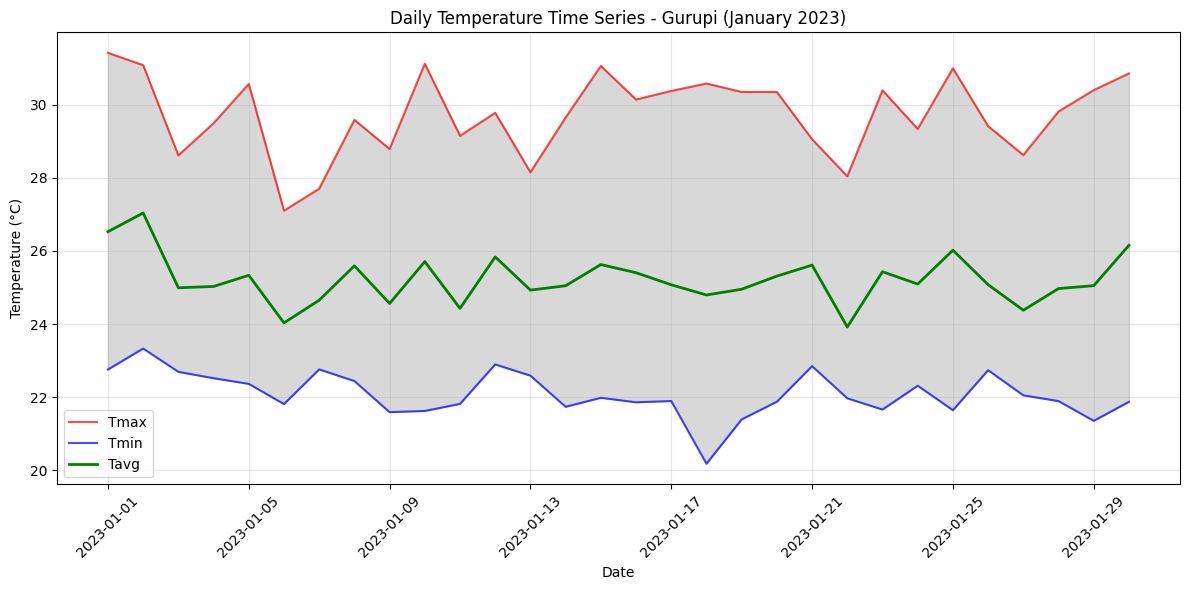

Temperature statistics for Gurupi:
            tmax       tmin       tavg
count  30.000000  30.000000  30.000000
mean   29.730552  22.085511  25.220756
std     1.109772   0.620151   0.681630
min    27.101556  20.185236  23.921313
25%    29.077501  21.759389  24.935880
50%    29.794283  21.935551  25.077175
75%    30.522542  22.574149  25.608085
max    31.414199  23.333180  27.037915


In [8]:
# Get sample temperature data for visualization
sample_data = daily_stats.limit(30)  # First 30 days

# Extract values for plotting (this is a simplified approach)
def extract_temp_values(image):
    # Reduce to mean value over city geometry
    values = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=first_city.geometry(),
        scale=11000,  # ERA5-Land resolution
        maxPixels=1e9
    )
    
    return ee.Feature(None, {
        'date': image.get('date'),
        'tmax': values.get('tmax'),
        'tmin': values.get('tmin'),
        'tavg': values.get('tavg')
    })

sample_features = sample_data.map(extract_temp_values)
sample_info = sample_features.getInfo()

# Convert to DataFrame for plotting
temp_data = []
for feature in sample_info['features']:
    props = feature['properties']
    temp_data.append({
        'date': props['date'],
        'tmax': props['tmax'],
        'tmin': props['tmin'],
        'tavg': props['tavg']
    })

df = pd.DataFrame(temp_data)
df['date'] = pd.to_datetime(df['date'])

# Plot temperature time series
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['tmax'], label='Tmax', color='red', alpha=0.7)
plt.plot(df['date'], df['tmin'], label='Tmin', color='blue', alpha=0.7)
plt.plot(df['date'], df['tavg'], label='Tavg', color='green', linewidth=2)

plt.fill_between(df['date'], df['tmin'], df['tmax'], alpha=0.3, color='gray')

plt.title(f'Daily Temperature Time Series - {city_name} (January 2023)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Temperature statistics for {city_name}:")
print(df[['tmax', 'tmin', 'tavg']].describe())

## Data Quality Assessment

In [21]:
# Assess data quality and completeness
print("Data Quality Assessment:")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {len(df)}")
print(f"Missing values:")
print(f"  - Tmax: {df['tmax'].isna().sum()}")
print(f"  - Tmin: {df['tmin'].isna().sum()}")
print(f"  - Tavg: {df['tavg'].isna().sum()}")

# Check for outliers
print(f"\nTemperature ranges:")
print(f"  - Tmax: {df['tmax'].min():.1f}°C to {df['tmax'].max():.1f}°C")
print(f"  - Tmin: {df['tmin'].min():.1f}°C to {df['tmin'].max():.1f}°C")
print(f"  - Tavg: {df['tavg'].min():.1f}°C to {df['tavg'].max():.1f}°C")

# Check logical consistency (Tmin <= Tavg <= Tmax)
consistent_data = (df['tmin'] <= df['tavg']) & (df['tavg'] <= df['tmax'])
print(f"\nData consistency: {consistent_data.sum()}/{len(df)} days are logically consistent")

Data Quality Assessment:
Date range: 2023-01-01 00:00:00 to 2023-01-30 00:00:00
Total days: 30
Missing values:
  - Tmax: 0
  - Tmin: 0
  - Tavg: 0

Temperature ranges:
  - Tmax: 27.1°C to 31.4°C
  - Tmin: 20.2°C to 23.3°C
  - Tavg: 23.9°C to 27.0°C

Data consistency: 30/30 days are logically consistent


## Batch Processing Setup

In [9]:
# Setup for batch processing multiple cities
def setup_batch_processing(cities_collection, sample_size=None):
    """
    Setup batch processing for multiple cities
    
    Parameters:
    - cities_collection: ee.FeatureCollection of cities
    - sample_size: Number of cities to process (None for all)
    
    Returns:
    - List of export tasks
    """
    
    if sample_size:
        cities_to_process = cities_collection.limit(sample_size)
    else:
        cities_to_process = cities_collection
    
    # Get city list
    city_list = cities_to_process.getInfo()['features']
    print(f"Setting up batch processing for {len(city_list)} cities")
    
    export_tasks = []
    
    for i, city_feature in enumerate(city_list):
        try:
            city_ee_feature = ee.Feature(city_feature)
            task = export_city_temperature_data(city_ee_feature)
            export_tasks.append(task)
            
            if i % 10 == 0:
                print(f"Processed {i+1}/{len(city_list)} cities")
                
        except Exception as e:
            city_name = city_feature['properties'].get('GC_UCN_MAI', 'Unknown')
            print(f"Error processing city {city_name}: {str(e)}")
            continue
    
    return export_tasks

# Example: Process first 5 cities
if GEE_INITIALIZED and cities is not None:
    print("Starting batch processing for 5 test cities...")
    tasks = setup_batch_processing(cities, sample_size=5)
    print(f"Started {len(tasks)} export tasks")
else:
    print("⚠️  Cannot start batch processing - GEE not initialized or cities not loaded")

Starting batch processing for 5 test cities...
Setting up batch processing for 5 cities
Processing city: Chimoio, Mozambique (ID: unknown)
Export task started for Chimoio
Processed 1/5 cities
Processing city: Gondola, Mozambique (ID: unknown)
Export task started for Gondola
Processing city: Gurupi, Brazil (ID: unknown)
Export task started for Gurupi
Processing city: Nhamatanda, Mozambique (ID: unknown)
Export task started for Nhamatanda
Processing city: Smila, Ukraine (ID: unknown)
Export task started for Smila
Started 5 export tasks


Note: from cell above ID is missing, need to replace the ID field with the name of the actual field from GHS data.... it is not: 'ID_HDC_G0'

## Task Monitoring

In [12]:
# Monitor export tasks
def monitor_tasks(task_list):
    """
    Monitor the status of export tasks
    """
    print("Task Status Summary:")
    print("-" * 50)
    
    status_counts = {}
    
    for i, task in enumerate(task_list):
        status = task.status()['state']
        description = task.status()['description']
        
        status_counts[status] = status_counts.get(status, 0) + 1
        
        print(f"Task {i+1}: {description} - {status}")
    
    print("\nOverall Status:")
    for status, count in status_counts.items():
        print(f"  {status}: {count} tasks")
    
    return status_counts

# Monitor current tasks
if 'tasks' in locals() and tasks:
    monitor_tasks(tasks)
else:
    print("No active tasks to monitor")

Task Status Summary:
--------------------------------------------------
Task 1: temperature_daily_unknown_Chimoio - COMPLETED
Task 2: temperature_daily_unknown_Gondola - COMPLETED
Task 3: temperature_daily_unknown_Gurupi - COMPLETED
Task 4: temperature_daily_unknown_Nhamatanda - COMPLETED
Task 5: temperature_daily_unknown_Smila - COMPLETED

Overall Status:
  COMPLETED: 5 tasks


## Next Steps

This notebook has completed Phase 1 of the EHF methodology implementation:

✅ **Completed:**
- ERA5-Land data access setup
- City-based analysis framework
- Temperature extraction and aggregation functions
- Daily statistics calculation (Tmax, Tmin, Tavg)
- Data quality assessment
- Batch processing framework

**Next Phase:** Proceed to Phase 2 notebook (`10_phase2_ehf_baseline.ipynb`) for:
- Climatological threshold (T95) calculation
- Long-term temperature statistics
- Baseline reference period establishment

**Data Output:** Temperature time series are being exported to Google Drive in folder `EHF_Temperature_Data/`